In [61]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import *
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

In [121]:
train_df = pd.read_csv("data/public_train_trx.csv")
test_df = pd.read_csv("data/public_test_trx.csv")
alldf = pd.concat([train_df,test_df])
alldf = alldf.sort_values(['session_id','duration_of_session','click_num'])
alldf = alldf.reset_index(drop=True)
target = 'TARGET_successful_purchase'

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [122]:
alldf['start_time_of_session_day_of_year'] = pd.to_datetime(alldf.start_date_of_session).dt.dayofyear
alldf['start_weekday_of_session'] = pd.to_datetime(alldf.start_date_of_session).dt.weekday
alldf['start_time_of_session_hour'] = pd.to_datetime(alldf.start_time_of_session).dt.hour
alldf['start_time_of_session_early'] = alldf['start_time_of_session_hour'] < 8

In [123]:
alldf = alldf.fillna(0)
# alldf['lifetime_customer_account'] = alldf['lifetime_customer_account'].replace(-1, 0)
aggregalando_valtozok = list(alldf.columns)
aggregalando_valtozok.remove('test_or_train_flag')
aggregalando_valtozok.remove(target)
aggregalando_valtozok.remove('start_date_of_session')
aggregalando_valtozok.remove('start_time_of_session')
aggregalando_valtozok.remove('session_id')

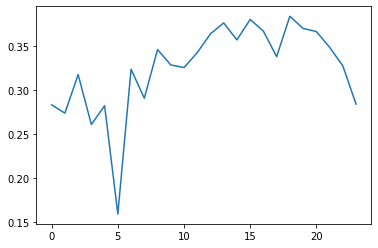

In [124]:
plt.plot(alldf.groupby('start_time_of_session_hour',as_index=False).agg({target:'mean'})['TARGET_successful_purchase'])

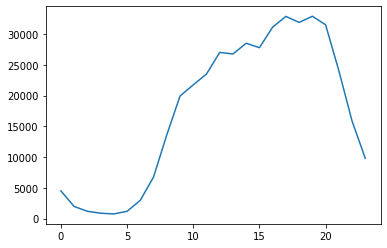

In [125]:
plt.plot(alldf.groupby('start_time_of_session_hour',as_index=False).agg({target:'count'})['TARGET_successful_purchase'])

In [126]:
alldf.groupby('start_time_of_session_hour',as_index=False).agg({target:'mean'})['TARGET_successful_purchase']

0     0.283010
1     0.273609
2     0.317447
3     0.260718
4     0.282086
5     0.158974
6     0.323549
7     0.290643
8     0.345948
9     0.328446
10    0.325468
11    0.342411
12    0.363781
13    0.376256
14    0.356930
15    0.380229
16    0.366884
17    0.337877
18    0.383834
19    0.369962
20    0.366440
21    0.348608
22    0.327448
23    0.283875
Name: TARGET_successful_purchase, dtype: float64

In [127]:
cust_df = alldf.groupby('session_id',as_index=False).agg({target:'min',
                                        'test_or_train_flag':'min'})
for aggregalos_modszer in ['min','max', 'mean']:
    task={}
    ujoszlonevek=[]
    for v in aggregalando_valtozok:
        task[v]=aggregalos_modszer
        ujoszlonevek.append(aggregalos_modszer+"_"+v)
    stat = alldf.groupby(['session_id'],as_index=False).agg(task)
    stat.columns=['session_id']+ujoszlonevek
    cust_df = cust_df.merge(stat,on='session_id',how='left')

In [128]:
cust_df['click_per_durr'] = cust_df['max_click_num'] / cust_df['max_duration_of_session']
cust_df['vis_price_per_durr'] = cust_df['max_sum_price_of_visited_products'] / cust_df['max_duration_of_session']
cust_df['basket_elem_per_durr'] = cust_df['max_basket_element_number'] / cust_df['max_duration_of_session']
cust_df['basket_sum_per_durr'] = cust_df['max_sum_price_of_products_in_basket'] / cust_df['max_duration_of_session']

cust_df['bought_elem_visited_price_ratio'] = cust_df['max_basket_element_number'] / cust_df['max_sum_price_of_visited_products']

cust_df['bought_price_visited_price_ratio'] = cust_df['max_sum_price_of_products_in_basket']  / cust_df['max_sum_price_of_visited_products']

cust_df['payment_per_cust_existance'] = cust_df['max_num_of_previous_payments'] / cust_df['max_lifetime_customer_account']

cust_df['max_registration_age'] = cust_df['max_customer_age'] - (cust_df['max_lifetime_customer_account'] / 365)

cust_df.replace(np.inf, 0, inplace=True)
cust_df.fillna(0, inplace=True)

In [145]:
from sklearn.preprocessing import PolynomialFeatures

bemeno_valtozok = list(cust_df.columns)[3:]
ismert_df = cust_df[ cust_df['test_or_train_flag']==0].copy()
# x_train = ismert_df[bemeno_valtozok]
# y_train = ismert_df[target]
# x_pred = cust_df[cust_df['test_or_train_flag'] == 1][bemeno_valtozok]

# poly = PolynomialFeatures(2)
# x_train = poly.fit_transform(x_train.to_numpy())
# x_pred = poly.transform(x_pred.to_numpy())

# scaler = StandardScaler()
# x_train = scaler.fit_transform(x_train)
# x_pred = scaler.transform(x_pred)
# print(f"Training set size: {x_train.shape}")

Training set size: (24584, 2628)


In [149]:
x_train.shape

(24584, 2628)

In [156]:
def rounding_score_decorator(score):
    return lambda y_true, y_pred: score(y_true, y_pred > 0.5)

def text2score(optimalization):
    if optimalization == 'AUC':
        score = roc_auc_score
    elif optimalization == 'Precision':
        score = rounding_score_decorator(precision_score)
    elif optimalization == 'Recall':
        score = rounding_score_decorator(recall_score)
    elif optimalization == 'Accuracy':
        score = rounding_score_decorator(accuracy_score)
    return score

def modell_evaluator(data, input_attributes, target_attribute, model, n=1):
    def test_attributes(fix_input, possible_inputs):
        best_score = -1
        best_input = None
        for possible_input in possible_inputs:
            x_train = data[fix_input + [possible_input]].to_numpy()
            poly = PolynomialFeatures(n)
            x_train = poly.fit_transform(x_train)
#             scaler = StandardScaler()
#             x_train = scaler.fit_transform(x_train)
            
            cv_results = cross_validate(model,
                            x_train, data[target_attribute],
                            scoring=['roc_auc', 'accuracy'], cv=3, n_jobs=4)
            s = cv_results['test_roc_auc'].mean()
            if s > best_score:
                best_score = s
                best_input = possible_input
        return best_input, best_score
    good_inputs = []
    in_race_inputs = input_attributes
    best_s = -1
    while len(in_race_inputs):
        i_to_accept, s = test_attributes(good_inputs, input_attributes)
        print(i_to_accept, s)
        if s < best_s:
            return best_s, good_inputs
        
        best_s = s
        good_inputs.append(i_to_accept)
        in_race_inputs.remove(i_to_accept)
    return best_s, good_inputs

In [157]:
from sklearn.linear_model import LogisticRegression

In [158]:
modell_evaluator(ismert_df, 
                 bemeno_valtozok, 
                 target,
                 LogisticRegression())

max_lifetime_customer_account 0.7050045185196421
max_duration_of_session 0.7433663851449169
min_duration_of_session 0.7661100375821808
mean_duration_of_session 0.7692782950250386
min_num_of_previous_payments 0.7702193797726485
mean_max_val 0.7705178616779677
max_regio_of_customer 0.770672150443447
mean_last_order_of_customer 0.7707314424640191
click_per_durr 0.7707019760090802


(0.7707314424640191,
 ['max_lifetime_customer_account',
  'max_duration_of_session',
  'min_duration_of_session',
  'mean_duration_of_session',
  'min_num_of_previous_payments',
  'mean_max_val',
  'max_regio_of_customer',
  'mean_last_order_of_customer'])

In [10]:
from sklearn.neighbors import *
modell_evaluator(ismert_df, 
                 bemeno_valtozok, 
                 target,
                 KNeighborsClassifier())

mean_click_num 0.6951923119628948
max_regio_of_customer 0.7409107179229348
click_per_durr 0.7638062863332604
min_click_num 0.7657512837800718
max_click_num 0.7929701943414699
mean_regio_of_customer 0.7936343947120671
min_regio_of_customer 0.7949950638083401
basket_elem_per_durr 0.795337225976568
min_basket_element_number 0.7954744961579913


KeyboardInterrupt: 

In [118]:
from sklearn.tree import *
modell_evaluator(ismert_df, 
                 bemeno_valtozok, 
                 target,
                 DecisionTreeClassifier())

max_lifetime_customer_account 0.7055599738134882
min_level_of_purchasing_process 0.7075005741604153
min_lifetime_customer_account 0.7069829434854574


(0.7075005741604153,
 ['max_lifetime_customer_account', 'min_level_of_purchasing_process'])

In [36]:
cv_results = cross_validate(DecisionTreeClassifier(max_depth = 6),
                            x_train, y_train,
                            scoring=['roc_auc', 'accuracy'], cv=3, n_jobs=4)
auc = cv_results['test_roc_auc'].mean()
print(f"\t{auc},\t{cv_results['test_accuracy'].mean()}")

	0.8666282542737099,	0.7918969712953853


In [ ]:
model = RandomForestClassifier(max_depth = 14, n_estimators = 1000)
model.fit(x_train, y_train)
pred = model.predict_proba(x_pred)
# accuracy_score(ismert_df[target],model.predict(ismert_df[bemeno_valtozok]))